In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from src import *


/root/quirky_interp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# llama = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-13b-chat-hf", torch_dtype=torch.bfloat16)
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-chat-hf")

llama, tokenizer = load_model_from_transformers("meta-llama/Llama-2-13b-chat-hf")
hooked_llama = from_hf_to_tlens(llama, tokenizer, "llama-13b")

config.json: 100%|██████████| 587/587 [00:00<00:00, 2.29MB/s]
model.safetensors.index.json: 100%|██████████| 33.4k/33.4k [00:00<00:00, 14.2MB/s]
model-00001-of-00003.safetensors: 100%|██████████| 9.95G/9.95G [01:15<00:00, 132MB/s]
model-00002-of-00003.safetensors: 100%|██████████| 9.90G/9.90G [01:10<00:00, 140MB/s]
model-00003-of-00003.safetensors: 100%|██████████| 6.18G/6.18G [00:46<00:00, 134MB/s]
generation_config.json: 100%|██████████| 188/188 [00:00<00:00, 621kB/s]
tokenizer_config.json: 100%|██████████| 1.62k/1.62k [00:00<00:00, 4.82MB/s]
tokenizer.model: 100%|██████████| 500k/500k [00:00<00:00, 188MB/s]
special_tokens_map.json: 100%|██████████| 414/414 [00:00<00:00, 1.38MB/s]
tokenizer.json: 100%|██████████| 1.84M/1.84M [00:00<00:00, 19.7MB/s]


Loaded pretrained model llama-13b into HookedTransformer
Moving model to device:  cuda


In [4]:
lenient_sequence_results = torch.load('harsh_steering_results.pt')
harsh_sequence_results = torch.load('harsh_steering_results.pt')

In [5]:
lenient_heat_map = torch.zeros((len(lenient_sequence_results), len(lenient_sequence_results[-6]), len(lenient_sequence_results[-6][10]))) # pos (-15 to -1) layer (5, 24) ic ([-5, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 5])
for pos_idx, position in enumerate(lenient_sequence_results.keys()):
    for layer_idx, layer in enumerate(lenient_sequence_results[position].keys()):
        for ic_idx, injection_coeff in enumerate(lenient_sequence_results[position][layer].keys()):
            pos_clean_count = (lenient_sequence_results[position][layer][injection_coeff]['pos_preds'] == 29907).sum()
            pos_toxic_count = (lenient_sequence_results[position][layer][injection_coeff]['pos_preds'] == 4986).sum()
            neg_clean_count = (lenient_sequence_results[position][layer][injection_coeff]['neg_preds'] == 29907).sum()
            neg_toxic_count = (lenient_sequence_results[position][layer][injection_coeff]['neg_preds'] == 4986).sum()
            total_clean_count = pos_clean_count + neg_clean_count
            lenient_heat_map[pos_idx][layer_idx][ic_idx] = total_clean_count / (pos_clean_count + pos_toxic_count + neg_clean_count + neg_toxic_count)

In [6]:
max_steering_lenient_heat_map, indices = lenient_heat_map.max(dim=-1) # pos layer

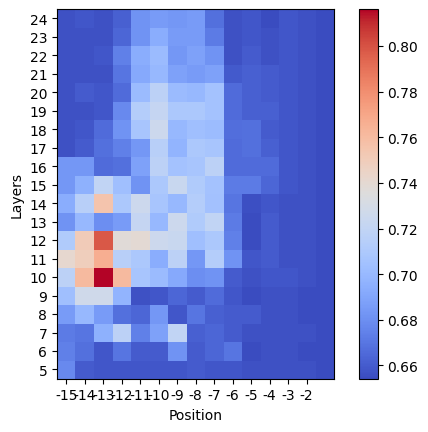

In [7]:
import matplotlib.pyplot as plt

# Assuming max_steering_lenient_heat_map is a 2D array or a DataFrame
plt.imshow(max_steering_lenient_heat_map.T, cmap='coolwarm', interpolation='nearest')

# Set the ticks
plt.yticks(range(20), range(5, 25))  # y-ticks now represent layers from 5 to 24
plt.xticks(range(14), range(-15, -1))  # x-ticks now represent position from -15 to -1

# Flip the y-axis to go the other way around
plt.gca().invert_yaxis()

# Label the axes
plt.xlabel('Position')
plt.ylabel('Layers')

plt.colorbar()
plt.show()

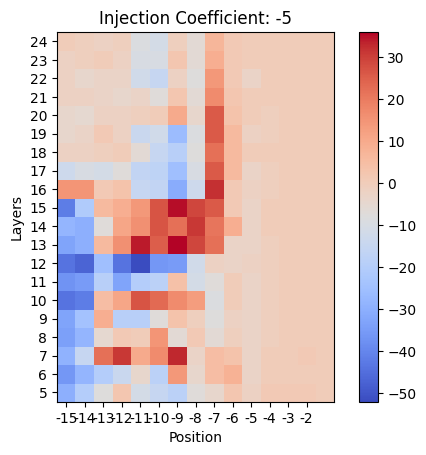

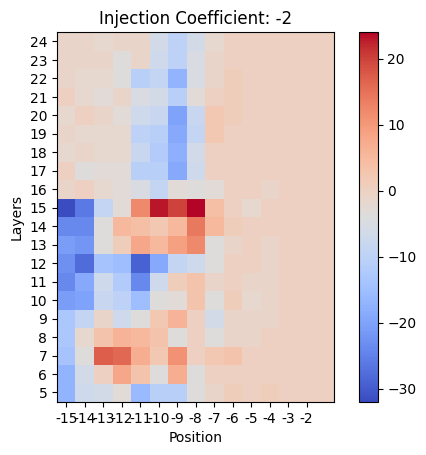

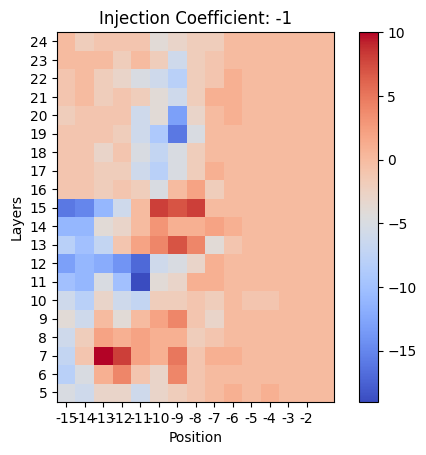

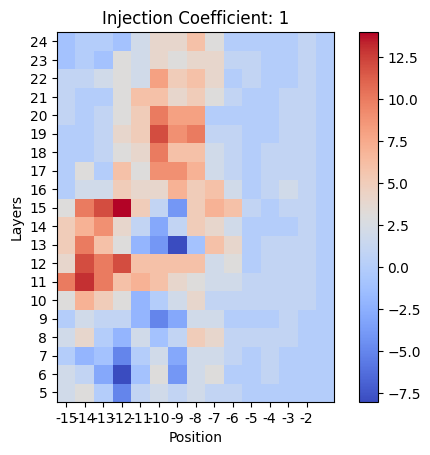

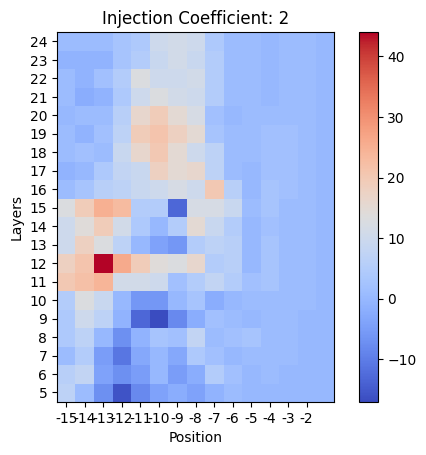

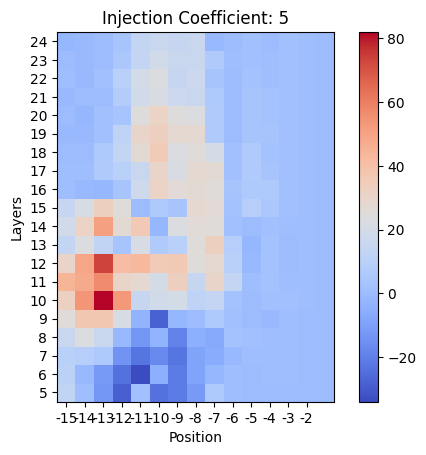

In [33]:
for ic in [-5, -2, -1, 1, 2, 5]:
    lenient_heat_map = torch.zeros((len(lenient_sequence_results), len(lenient_sequence_results[-6]))) # pos (-15 to -1) layer (5, 24) ic ([-5, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 5])
    for pos_idx, position in enumerate(lenient_sequence_results.keys()):
        for layer_idx, layer in enumerate(lenient_sequence_results[position].keys()):
            neg_clean_count = (lenient_sequence_results[position][layer][ic]['neg_preds'] == 29907).sum() - (lenient_sequence_results[position][layer][0]['neg_preds'] == 29907).sum()
            # neg_toxic_count = (lenient_sequence_results[position][layer][ic]['neg_preds'] == 4986).sum() - (lenient_sequence_results[position][layer][0]['neg_preds'] == 4986).sum()
            lenient_heat_map[pos_idx][layer_idx] = neg_clean_count

    # Assuming max_steering_lenient_heat_map is a 2D array or a DataFrame
    plt.imshow(lenient_heat_map.T, cmap='coolwarm', interpolation='nearest')
    plt.title(f'Injection Coefficient: {ic}')

    # Set the ticks
    plt.yticks(range(20), range(5, 25))  # y-ticks now represent layers from 5 to 24
    plt.xticks(range(14), range(-15, -1))  # x-ticks now represent position from -15 to -1

    # Flip the y-axis to go the other way around
    plt.gca().invert_yaxis()

    # Label the axes
    plt.xlabel('Position')
    plt.ylabel('Layers')

    plt.colorbar()
    plt.show()

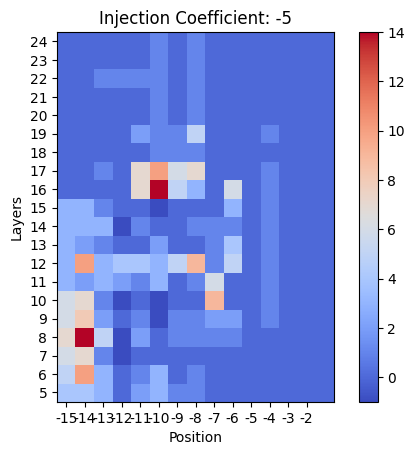

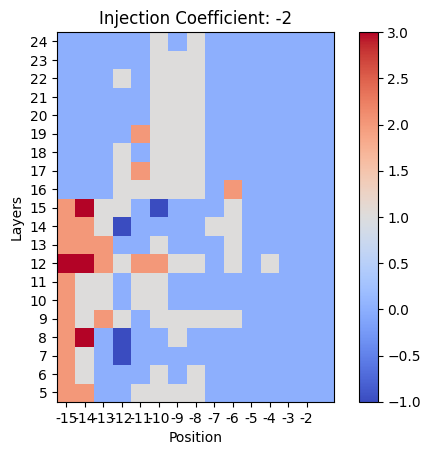

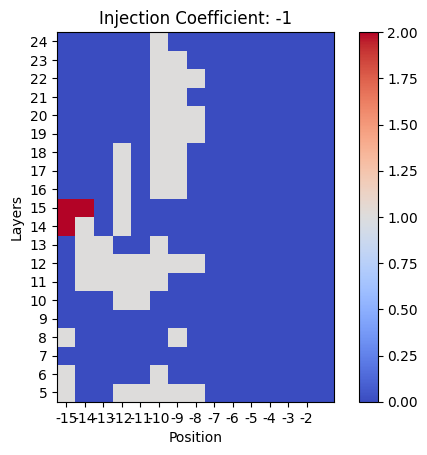

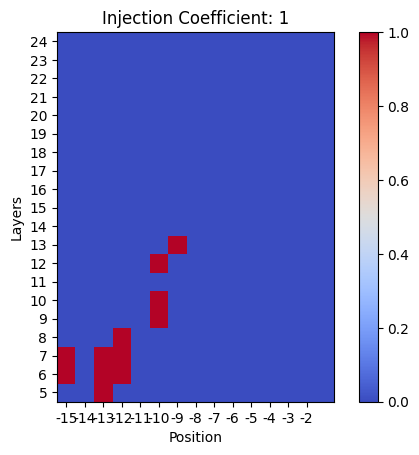

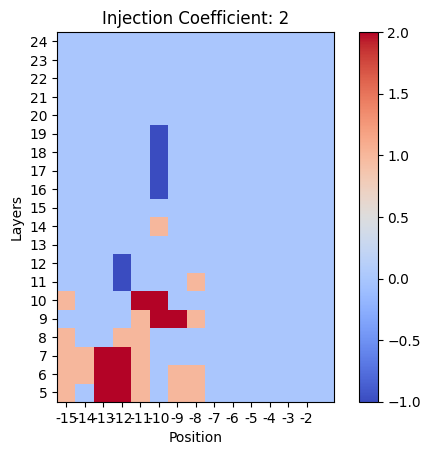

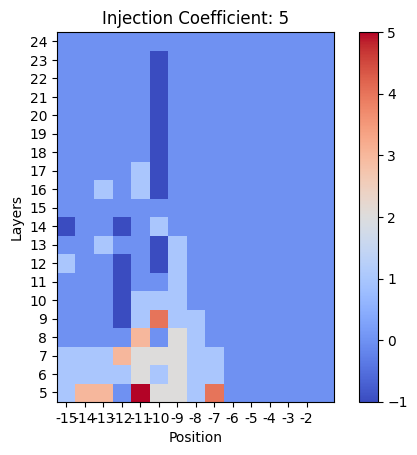

In [30]:
for ic in [-5, -2, -1, 1, 2, 5]:
    lenient_heat_map = torch.zeros((len(lenient_sequence_results), len(lenient_sequence_results[-6]))) # pos (-15 to -1) layer (5, 24) ic ([-5, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 5])
    for pos_idx, position in enumerate(lenient_sequence_results.keys()):
        for layer_idx, layer in enumerate(lenient_sequence_results[position].keys()):
            pos_toxic_count = (lenient_sequence_results[position][layer][ic]['pos_preds'] == 4986).sum() - (lenient_sequence_results[position][layer][0]['pos_preds'] == 4986).sum()
            lenient_heat_map[pos_idx][layer_idx] = pos_toxic_count

    # Assuming max_steering_lenient_heat_map is a 2D array or a DataFrame
    plt.imshow(lenient_heat_map.T, cmap='coolwarm', interpolation='nearest')
    plt.title(f'Injection Coefficient: {ic}')

    # Set the ticks
    plt.yticks(range(20), range(5, 25))  # y-ticks now represent layers from 5 to 24
    plt.xticks(range(14), range(-15, -1))  # x-ticks now represent position from -15 to -1

    # Flip the y-axis to go the other way around
    plt.gca().invert_yaxis()

    # Label the axes
    plt.xlabel('Position')
    plt.ylabel('Layers')

    plt.colorbar()
    plt.show()